In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [4]:
depression_df = pd.read_csv("cleaned_depression.csv") 

# prepare features and target
features = depression_df.drop(columns=['depression'])
target = depression_df['depression']

# one-hot encode categorical features
features_encoded = pd.get_dummies(features)

# scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_encoded)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42, stratify=target
)

# tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# evaluate
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      2313
           1       0.85      0.89      0.87      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581

Confusion Matrix:
 [[1783  530]
 [ 372 2896]]
ROC AUC Score: 0.9149355910211086


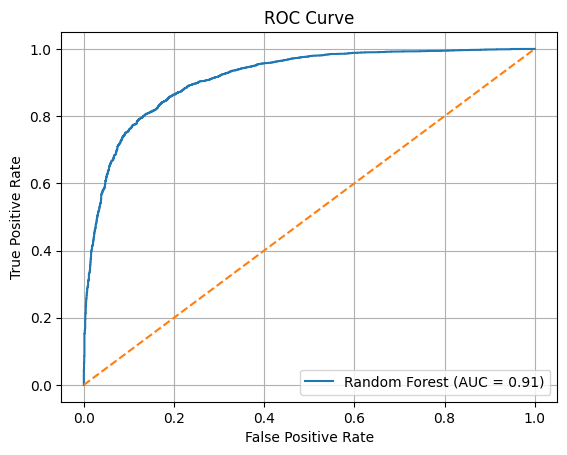

In [5]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [6]:
df = pd.read_csv("cleaned_performance.csv")

# grade mapping from letter to numeric score
grade_mapping = {
    'A': 90,
    'B': 80,
    'C': 70,
    'D': 60,
    'F': 50
}
df['grade_numeric'] = df['grade'].map(grade_mapping)

# drop rows where grade couldn't be mapped
df = df.dropna(subset=['grade_numeric'])

# create target variable: pass (1) if grade >= 60, else fail (0)
df['pass_fail'] = df['grade_numeric'].apply(lambda x: 1 if x >= 60 else 0)

# drop columns not useful for modeling
drop_cols = ['student_id', 'first_name', 'last_name', 'email', 'grade', 'grade_numeric']
df = df.drop(columns=drop_cols, errors='ignore')

# one-hot encode cat columns
df = df.fillna("Missing")  # replace missing values in cat columns
X = pd.get_dummies(df.drop(columns=['pass_fail']), drop_first=True)
y = df['pass_fail']

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train - test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# random rorest grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(
    rf,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.02      0.04       201
           1       0.80      0.97      0.88       799

    accuracy                           0.78      1000
   macro avg       0.48      0.50      0.46      1000
weighted avg       0.67      0.78      0.71      1000

Confusion Matrix:
 [[  4 197]
 [ 20 779]]
ROC AUC Score: 0.5135835216906706


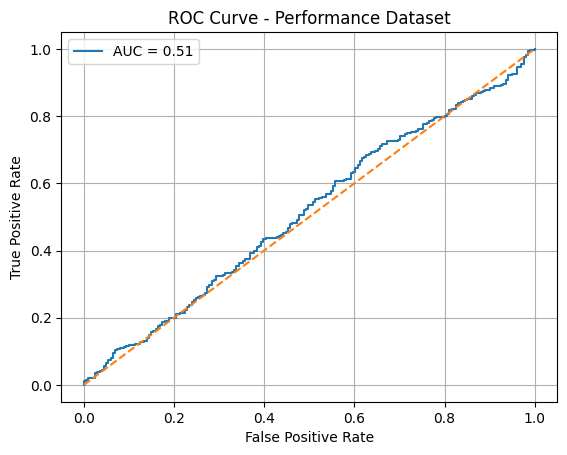

In [7]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - Performance Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend()
plt.show()